# **Modeling and Evaluation Notebook**
## Objectives

Address Business Requirement 2:

    Develop a Machine Learning model to classify cherry leaves as Healthy or Infected, enabling reliable detection of powdery mildew in the field.

📂 Inputs
📁 Dataset

    inputs/datasets/raw/cherry-leaves/train

    inputs/datasets/raw/cherry-leaves/validation

    inputs/datasets/raw/cherry-leaves/test

## Insights from the Previous (Data Visualization) Notebook

     Image Resizing & Standardization → All images resized to 128x128x3 for consistent model input.

     Balanced Class Distribution → Verified across train/val/test sets to prevent bias.

     Brightness & Pixel Variability → Confirmed statistically via t-test; supports class differentiation.

     Feature Space Visualizations:

        PCA showed partial linear separability.

        t-SNE revealed more structure but some overlap.

        UMAP showed clearer separation, highlighting non-linear geometry — suggesting strong model potential.

## Outputs


## Additional Comments


## Import packages for notebook

In [1]:
import os
import joblib
import sys
import tensorflow as tf
import numpy as np
import random
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    accuracy_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

# Add the ressource directory to our path to be able to load relevant functions
sys.path.append('./src')

In [2]:
seed = 21
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Set working directory

As the notebooks are set in a subfolder of this repo we need to adjust the working directory so files can be accessed properly. 

First we check our current working directory.

In [3]:
current_dir = os.getcwd()
current_dir

'e:\\Projects\\Code-I\\vscode-projects\\PP5-predictive_analysis\\jupyter_notebooks'

Now we can change the directory to the parent folder that contains the complete repo. We will also print our new working directory so we can check everything worked out as planned.

In [4]:
# Only change the directory if not already at the repo root
current_dir = os.getcwd()
target_dir = os.path.abspath(os.path.join(current_dir, os.pardir))  # One level up

# Check if we're already in the repo root
if os.path.basename(current_dir) == 'jupyter_notebooks':
    os.chdir(target_dir)
    current_dir = os.getcwd()
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Current working directory remains: {current_dir}")

Working directory set to: e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis


## Define data directories

In [5]:
# define variable for data directory
data_dir = os.path.join(os.getcwd(), 'inputs/datasets/raw/cherry-leaves')
# define variable for train set directory
train_dir = os.path.join(data_dir, 'train')
# define variable for test set directory
test_dir = os.path.join(data_dir, 'test')
# define variable for test set directory
val_dir = os.path.join(data_dir, 'validation')

## Define output directory

In [6]:
# Set the current version
version = 'v1'
# Define the  directory
output_dir = os.path.join(current_dir, 'outputs', version)

# Check if the versioned output directory already exists
if os.path.exists(output_dir):
    print(f"Output directory '{output_dir}' already exists. "
          "Please create a new version.")
else:
    os.makedirs(output_dir)
    print(f"Created output directory: '{output_dir}'")

Output directory 'e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\outputs\v1' already exists. Please create a new version.


## Load image shape definition

In [7]:
# define image dimensions and save for reuse
img_shape = joblib.load(f"{output_dir}/img_shape.pkl")
img_shape

(128, 128, 3)

## Recount number of images in train, test and validation data

In this step we will have another look at size and distribution of the datasets

* train - healthy: 1472 images
* train - diseased: 1472 images
* validation - healthy: 315 images
* validation - diseased: 315 images
* test - healthy: 317 images
* test - diseased: 317 images


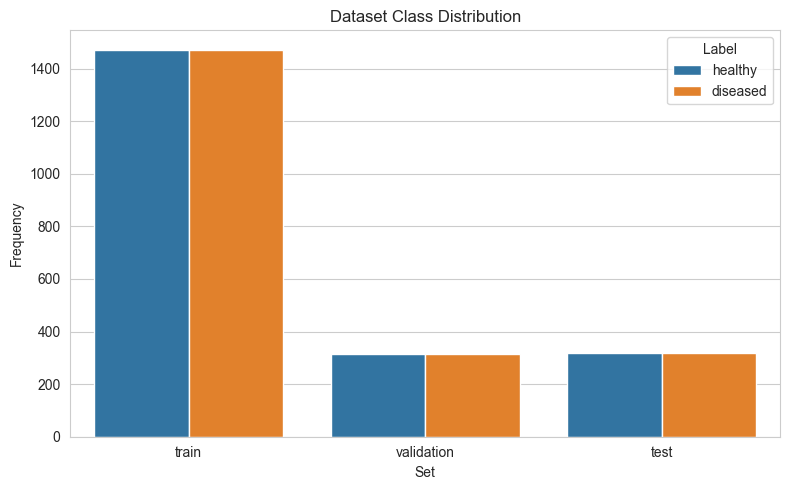

In [8]:
from modelling import get_split_counts
from modelling import plot_split_distribution

labels = ['healthy', 'diseased']
splits = ['train', 'validation', 'test']

df_freq = get_split_counts(data_dir, splits=splits, labels=labels)
plot_split_distribution(df_freq, save_path=f"{output_dir}/labels_distribution.png")


This distribution does point toward applying data augmentation, though not because of imbalance — it's balanced — but because of limited data volume, especially in the validation and test sets.
In total we have about 4200 images, this is modest for training deep learning models.
Augmentation will help with model generalization as it helps the model learn to handle varied real-world conditions (lighting, angle, background). It will also regularize the model and reduce overfitting.

## Data augmentation

We will use the image data generator from keras, as it is an out of the box generator that will (based on our settings) apply the standard modifications to distort our images and create new data. This includes rotation width and height shift, zooming in and out, flipping the image, changing brightness and shearing.

### Initialize image generator

In [9]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_aug = ImageDataGenerator(rescale=1./255)

We will augment  our train set with the train_aug definition.
For the validation & test sets we will not augment and just rescale=1./255. To leave them untouched to reflect real-world performance.

### Augment training data set

---

In [10]:
# Create data generator from directory
train_set = train_aug.flow_from_directory(
    train_dir,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

# Inspect class labels
print(train_set.class_indices)

Found 2944 images belonging to 2 classes.
{'diseased': 0, 'healthy': 1}


### Rescale validation data set

---

In [11]:
validation_set = val_test_aug.flow_from_directory(
    val_dir,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Usually no shuffle for validation/test
)

Found 630 images belonging to 2 classes.


### Rescale test data set

---

In [12]:
test_set = val_test_aug.flow_from_directory(
    test_dir,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=16,
    class_mode='binary',
    shuffle=False,
    seed=seed
)

Found 634 images belonging to 2 classes.


### Plot exemplary augmented training images

---

(16, 128, 128, 3)


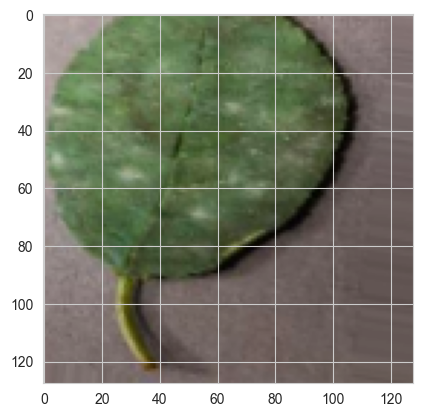

(16, 128, 128, 3)


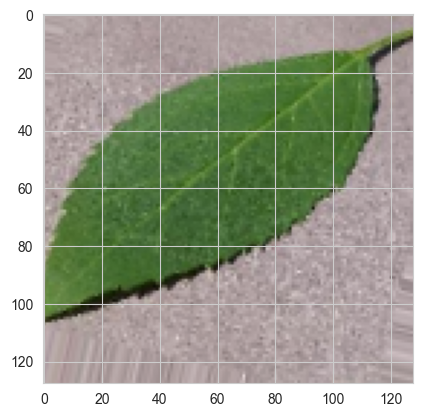

In [13]:
for i in range(2):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot exemplary rescaled validation images

---

(16, 128, 128, 3)


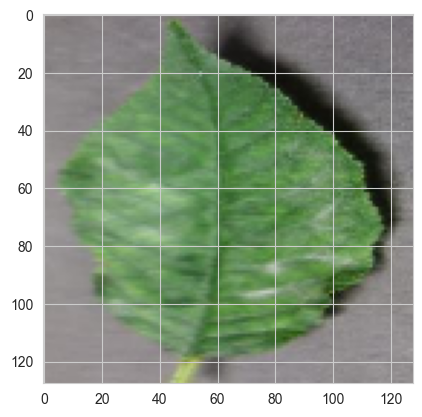

(16, 128, 128, 3)


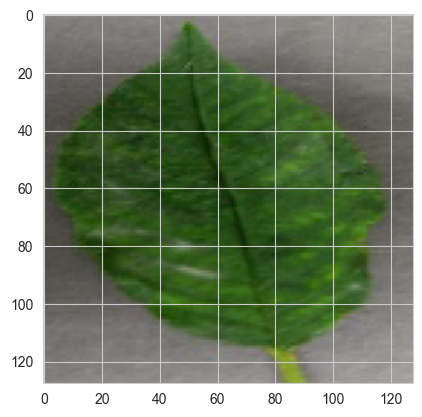

In [14]:
for i in range(2):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot exemplary rescaled test images

---

(16, 128, 128, 3)


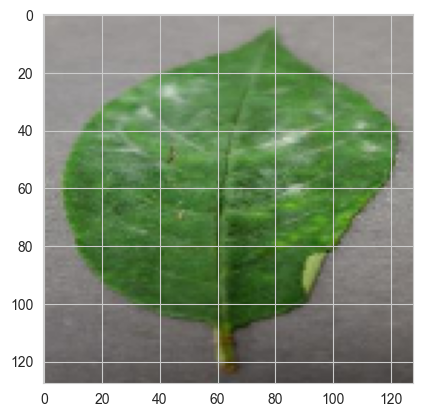

(16, 128, 128, 3)


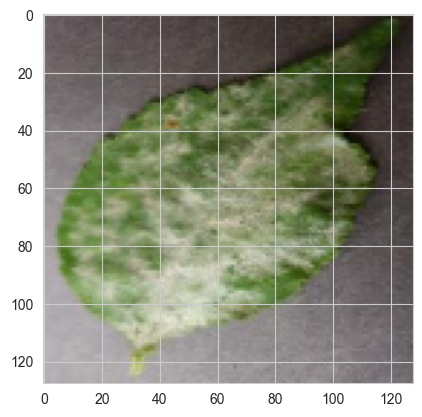

In [15]:
for i in range(2):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

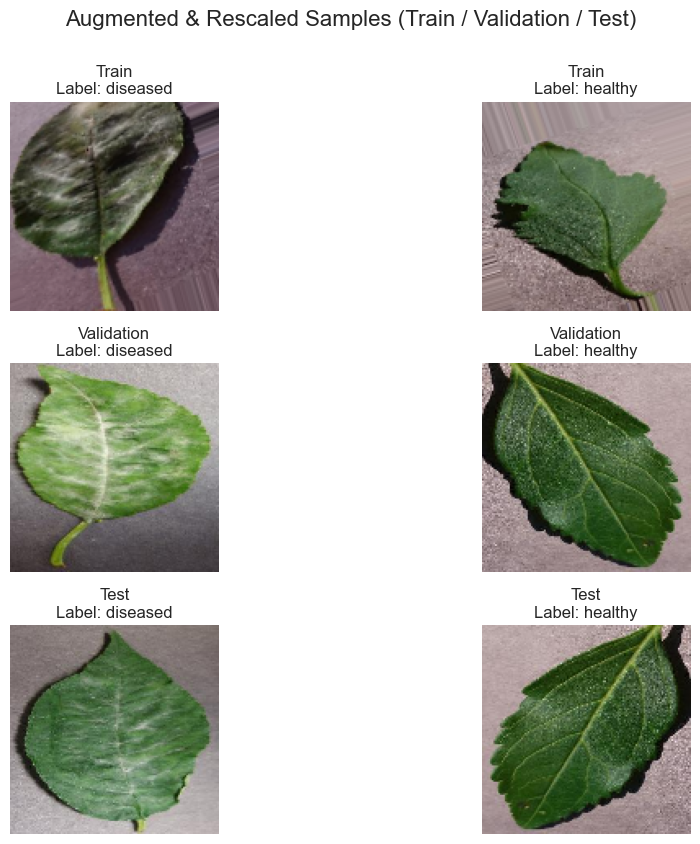

In [16]:
from modelling import plot_augmented_samples_grid

# Create small generators with shuffle=True to pull random samples
generators = {
    'train': train_set,
    'validation': validation_set,
    'test': test_set
}

plot_augmented_samples_grid(generators, train_set.class_indices)

### Save class indices

In [17]:
joblib.dump(value=train_set.class_indices,
            filename=f"{output_dir}/class_indices.pkl")

['e:\\Projects\\Code-I\\vscode-projects\\PP5-predictive_analysis\\outputs\\v1/class_indices.pkl']

---

## Modelling

---

We will start wis a simple baseline convoluted neural network (CNN) this helps to establish a benchmark. Our CNN will be shallow (2-3 convolutional layers) this makes it quick to train and easily interpretable.

In [18]:
from modelling import build_custom_cnn

model = build_custom_cnn()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,529 (8.36 MB)

 Trainable params: 2,190,529 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(f'{output_dir}/mildew_detector.h5', save_best_only=True)
]

In [20]:
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=25,  # Or whatever number suits your patience & needs
    callbacks=callbacks,
    verbose=1
)

Epoch 1/25


e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7301 - loss: 0.5064

184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.7307 - loss: 0.5057 - val_accuracy: 0.9381 - val_loss: 0.1650
Epoch 2/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9420 - loss: 0.1747

184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.9421 - loss: 0.1745 - val_accuracy: 0.9587 - val_loss: 0.0921
Epoch 3/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9725 - loss: 0.0992

184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9725 - loss: 0.0991 - val_accuracy: 0.9905 - val_loss: 0.0344
Epoch 4/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9870 - loss: 0.0495 - val_accuracy: 0.9730 - val_loss: 0.0659
Epoch 5/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9903 - loss: 0.0357

184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.9903 - loss: 0.0356 - val_accuracy: 0.9984 - val_loss: 0.0120
Epoch 6/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9943 - loss: 0.0201

184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.9943 - loss: 0.0201 - val_accuracy: 0.9984 - val_loss: 0.0081
Epoch 7/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9943 - loss: 0.0217

184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9943 - loss: 0.0217 - val_accuracy: 0.9984 - val_loss: 0.0069
Epoch 8/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9959 - loss: 0.0186 - val_accuracy: 0.9968 - val_loss: 0.0230
Epoch 9/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.9934 - loss: 0.0172 - val_accuracy: 0.9952 - val_loss: 0.0215
Epoch 10/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9973 - loss: 0.0104 - val_accuracy: 0.9984 - val_loss: 0.0151
Epoch 11/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9978 - loss: 0.0148

184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.9978 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 12/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9956 - loss: 0.0139 - val_accuracy: 0.9968 - val_loss: 0.0117
Epoch 13/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9956 - loss: 0.0154 - val_accuracy: 0.9952 - val_loss: 0.0182
Epoch 14/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9972 - loss: 0.0108 - val_accuracy: 0.9889 - val_loss: 0.0392
Epoch 15/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.9906 - loss: 0.0163 - val_accuracy: 0.9952 - val_loss: 0.0216
Epoch 16/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.9962 - loss: 0.0161 - val_accuracy: 0.9984 - val_loss: 0.0044


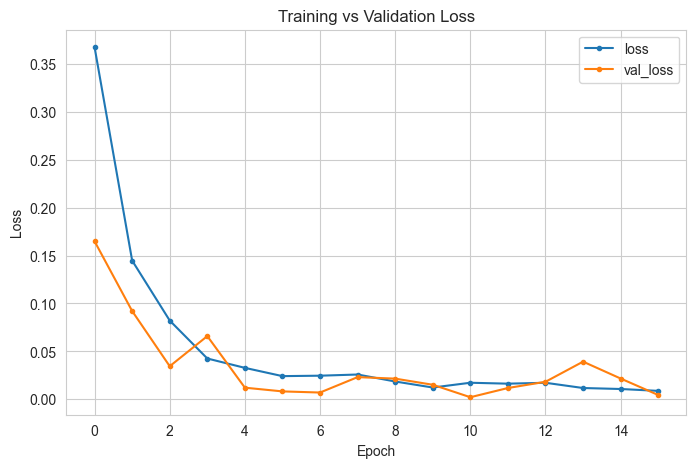

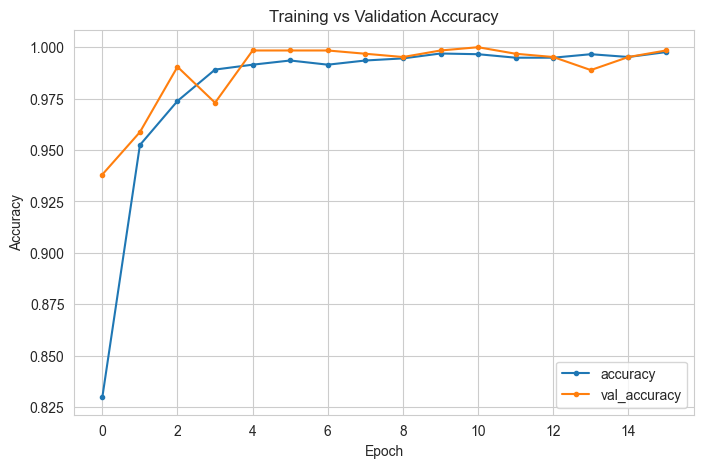

In [21]:
from modelling import plot_training_curves

plot_training_curves(history, output_dir="outputs", save_figures=True)

## Interpretation of training and validation curves

1. Accuracy Curve
The training and validation accuracy curves show a steady and rapid increase within the first few epochs, with both eventually converging above 99%. This indicates that the model has learned to classify the data very effectively and is capable of fitting both the training and validation sets well.

2. Loss Curve
Both training and validation losses exhibit a clear downward trend, with training loss reaching near zero and validation loss staying consistently low. The absence of significant spikes or divergence suggests the model has not overfit to the training data.

3. Generalization
The narrow and stable gap between training and validation accuracy/loss across epochs is a strong indicator of good generalization. The model performs well not only on training data but also on unseen validation samples — a key trait for real-world deployment.

## Model evaluation

In [22]:
model = load_model(f'outputs/{version}/mildew_detector.h5')

In [23]:
evaluation = model.evaluate(test_set)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ", evaluation[0])

e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 6.7752e-04
Model accuracy: 100.00%
Model Loss:  0.0020303509663790464


## Visualize model performance and statistics

First we are collecting predictions from the models on all three splits to visualize the in diffrerent manners

In [ ]:
from modelling import collect_predictions

y_true_train, y_probs_train = collect_predictions(train_set, model)
y_true_test, y_probs_test = collect_predictions(test_set, model)
y_true_val, y_probs_val = collect_predictions(validation_set, model)

## Create model confusion matrix

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


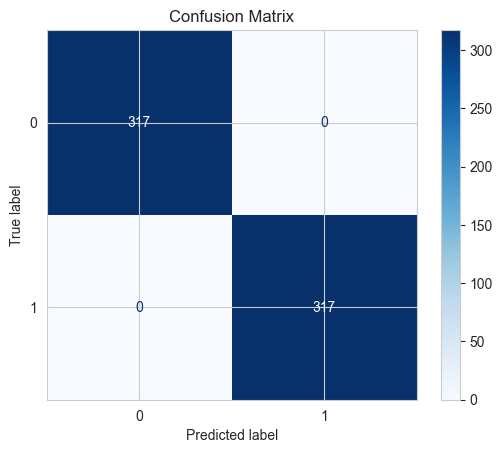

In [ ]:
cm = confusion_matrix(y_true_test, y_probs_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix Test")
plt.savefig(f"{output_dir}/confusion_matrix.png", bbox_inches="tight", dpi=150)
plt.show()

cm = confusion_matrix(y_true_val, y_probs_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix Validation")
plt.savefig(f"{output_dir}/confusion_matrix.png", bbox_inches="tight", dpi=150)
plt.show()

cm = confusion_matrix(y_true_train, y_probs_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix Training")
plt.savefig(f"{output_dir}/confusion_matrix.png", bbox_inches="tight", dpi=150)
plt.show()

## Create a classification report

Gives precision, recall, f1-score, which are crucial in class imbalance scenarios.

In [ ]:
class_names = list(test_set.class_indices.keys())
print('Classification report for Test Set:')
print(classification_report(y_true_test, y_probs_test, target_names=class_names))

print('Classification report for Validation Set:')
print(classification_report(y_true_val, y_probs_val, target_names=class_names))

print('Classification report for Train Set:')
print(classification_report(y_true_train, y_probs_train, target_names=class_names))

              precision    recall  f1-score   support

    diseased       0.52      0.53      0.52      1472
     healthy       0.52      0.51      0.51      1472

    accuracy                           0.52      2944
   macro avg       0.52      0.52      0.52      2944
weighted avg       0.52      0.52      0.52      2944



In [41]:
# Generate classification reports as dictionaries
report_train = classification_report(
    y_true_train, y_pred_train, target_names=label_map, output_dict=True
)
report_test = classification_report(
    y_true_test, y_pred_test, target_names=label_map, output_dict=True
)

# Convert to DataFrame
df_train = pd.DataFrame(report_train).transpose().round(3)
df_test = pd.DataFrame(report_test).transpose().round(3)

# Print Train Report
print("\n### Classification Report - Train Set ###\n")
print(df_train)

# Print Test Report
print("\n### Classification Report - Test Set ###\n")
print(df_test)

# Save reports as CSV for future reference
df_train.to_csv(f"{output_dir}/classification_report_train.csv")
df_test.to_csv(f"{output_dir}/classification_report_test.csv")

print(
    f"\nReports saved to {output_dir}/classification_report_train.csv & {output_dir}/classification_report_test.csv"
)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

## ROC Curve and AUC

Helpful for multi-class or imbalanced data. AUC > 0.90 is usually strong.

184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


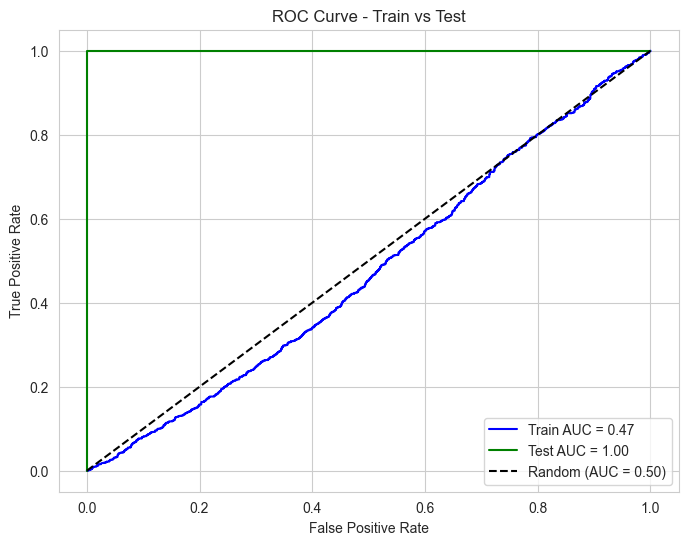

ROC Curve saved at: outputs/v1\roc_curve.png


In [42]:
# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)

# Generate predictions (probabilities)
y_probs_train = model.predict(train_set).ravel()
y_probs_test = model.predict(test_set).ravel()

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(
    y_true_train, y_probs_train
)  # Use class 1 probability
fpr_test, tpr_test, _ = roc_curve(
    y_true_test, y_probs_test
)  # Use class 1 probability

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Create static ROC curve using Matplotlib
plt.figure(figsize=(8, 6))

# Plot Train ROC
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.2f}", color="blue")

# Plot Test ROC
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.2f}", color="green")

# Plot Random Guess Line (Baseline)
plt.plot([0, 1], [0, 1], linestyle="dashed", color="black", label="Random (AUC = 0.50)")

# Labels and Title
plt.title("ROC Curve - Train vs Test")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Define file path
roc_curve_path = os.path.join(output_dir, "roc_curve.png")

# Save the figure as a static PNG
plt.savefig(roc_curve_path, dpi=150, bbox_inches="tight")

# Show the static ROC curve in the notebook
plt.show()

print(f"ROC Curve saved at: {roc_curve_path}")

## Per class accuracy barplot

Why: See which classes are hardest to classify.

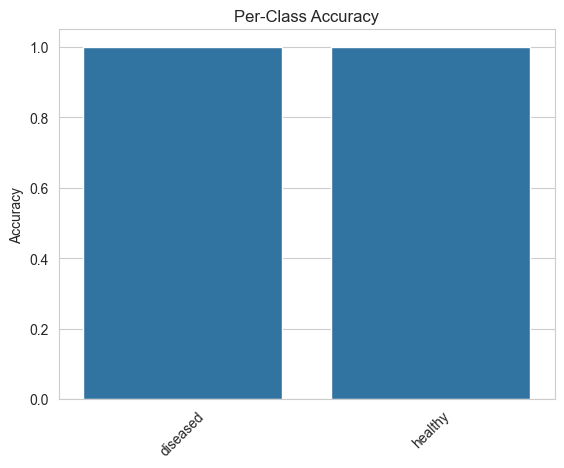

In [43]:
per_class_acc = []
for i in range(len(class_names)):
    idx = y_true == i
    acc = accuracy_score(y_true[idx], y_pred_classes[idx])
    per_class_acc.append(acc)

sns.barplot(x=class_names, y=per_class_acc)
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

## View misclassified Samples

Helps qualitatively understand errors — are they ambiguous?

In [44]:
misclassified_idxs = np.where(y_pred_classes != y_true)[0]
for i in misclassified_idxs[:5]:  # show first 5
    plt.imshow(X_test[i])  # or inverse transform if preprocessed
    plt.title(f"True: {class_names[y_true[i]]} | Pred: {class_names[y_pred_classes[i]]}")
    plt.axis('off')
    plt.show()

## Prediction confidence histogram

See how confident the model is — are wrong predictions highly confident?

### Save evaluation as a pkl file

In [33]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/eval.pkl")

['outputs/v1/eval.pkl']

## Predict on new data

In [45]:
train_files = set(train_set.filenames)
test_files = set(test_set.filenames)


overlap = train_files.intersection(test_files)
print(f"Number of overlapping files: {len(overlap)}")
if len(overlap) > 0:
    print("Leaked files:", list(overlap)[:5])

Number of overlapping files: 0


In [46]:
import os
import hashlib
from PIL import Image

def hash_image(image_path):
    with Image.open(image_path) as img:
        return hashlib.md5(img.tobytes()).hexdigest()

def get_image_hashes(base_dir, relative_paths):
    return {
        path: hash_image(os.path.join(base_dir, path))
        for path in relative_paths
    }

# Example: if your original dataset was loaded with
# train_set = flow_from_directory("data/train", ...)
# test_set = flow_from_directory("data/test", ...)


train_hashes = get_image_hashes(train_dir, train_set.filenames)
test_hashes = get_image_hashes(test_dir, test_set.filenames)

# Now compare the hashes
train_hash_set = set(train_hashes.values())
test_hash_set = set(test_hashes.values())

overlap = train_hash_set.intersection(test_hash_set)

print(f"Duplicate images by content: {len(overlap)}")

Duplicate images by content: 0


In [ ]:
# Make a copy of the test set labels
true_labels = test_set.labels.copy()
shuffled_labels = np.random.permutation(true_labels)

# Evaluate on the test set with correct images but wrong labels
loss, acc = model.evaluate(test_set)
print(f"Original test accuracy: {acc:.4f}")

# Now evaluate with shuffled labels (simulate with manual comparison)
preds = model.predict(test_set)
pred_classes = np.argmax(preds, axis=1)

# Compare to shuffled labels
acc_shuffled = np.mean(pred_classes == shuffled_labels)
print(f"Accuracy on shuffled test labels: {acc_shuffled:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 6.7752e-04
Original test accuracy: 1.0000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Accuracy on shuffled test labels: 0.5000


In [ ]:
from modelling import run_kfold

run_kfold(data_dir='inputs/datasets/raw/cherry-leaves', k=5, epochs=5)


🌀 Fold 1/5
Found 3367 validated image filenames belonging to 2 classes.
Found 841 validated image filenames belonging to 2 classes.
Epoch 1/5


e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.7981 - loss: 0.4437 - val_accuracy: 0.8597 - val_loss: 0.2871
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.9704 - loss: 0.0979 - val_accuracy: 0.9952 - val_loss: 0.0306
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9938 - loss: 0.0378 - val_accuracy: 0.9976 - val_loss: 0.0149
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.9966 - loss: 0.0207 - val_accuracy: 0.9988 - val_loss: 0.0064
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.9987 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0087
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 0.0077
✅ Fold 1 - Val Accuracy: 1.0000

🌀 Fold 2/5
Found 3365 validated image filenames belonging to 2 classes.
Found 843 validated image filenames belonging to 2 classes.
Epoch 1/5


e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 6 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.7692 - loss: 0.4716 - val_accuracy: 0.9786 - val_loss: 0.1058
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.9839 - loss: 0.0822 - val_accuracy: 0.9917 - val_loss: 0.0410
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9935 - loss: 0.0345 - val_accuracy: 0.9988 - val_loss: 0.0165
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.9959 - loss: 0.0249 - val_accuracy: 0.9988 - val_loss: 0.0108
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.9996 - loss: 0.0102 - val_accuracy: 0.9988 - val_loss: 0.0104
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9995 - loss: 0.0113
✅ Fold 2 - Val Accuracy: 0.9988

🌀 Fold 3/5
Found 3366 validated image filenames belonging to 2 classes.
Found 842 validated image filenames belonging to 2 classes.
Epoch 1/5


e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.7190 - loss: 0.5018 - val_accuracy: 0.9572 - val_loss: 0.1593
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.9712 - loss: 0.0947 - val_accuracy: 0.9929 - val_loss: 0.0466
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.9902 - loss: 0.0382 - val_accuracy: 0.9834 - val_loss: 0.0451
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9979 - loss: 0.0189 - val_accuracy: 0.9988 - val_loss: 0.0101
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.9997 - loss: 0.0060 - val_accuracy: 0.9976 - val_loss: 0.0104
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9941 - loss: 0.0172
✅ Fold 3 - Val Accuracy: 0.9976

🌀 Fold 4/5
Found 3368 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Epoch 1/5


e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.7263 - loss: 0.5090 - val_accuracy: 0.9560 - val_loss: 0.1534
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9709 - loss: 0.1023 - val_accuracy: 0.9845 - val_loss: 0.0701
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9897 - loss: 0.0506 - val_accuracy: 0.9774 - val_loss: 0.0608
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9950 - loss: 0.0279 - val_accuracy: 0.9952 - val_loss: 0.0191
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9973 - loss: 0.0165 - val_accuracy: 0.9952 - val_loss: 0.0138
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9900 - loss: 0.0252
✅ Fold 4 - Val Accuracy: 0.9952

🌀 Fold 5/5
Found 3366 validated image filenames belonging to 2 classes.
Found 842 validated image filenames belonging to 2 classes.


e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 6 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5


e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.7533 - loss: 0.4854 - val_accuracy: 0.9656 - val_loss: 0.1440
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9710 - loss: 0.1241 - val_accuracy: 0.9869 - val_loss: 0.0537
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9895 - loss: 0.0495 - val_accuracy: 0.9976 - val_loss: 0.0231
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9957 - loss: 0.0220 - val_accuracy: 0.9988 - val_loss: 0.0127
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.9991 - loss: 0.0078 - val_accuracy: 0.9988 - val_loss: 0.0077
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9956 - loss: 0.0173
✅ Fold 5 - Val Accuracy: 0.9988

 K-Fold Results:
Fold 1: Val Acc = 1.0000, Val Loss = 0.0087
Fold 2: Val Acc = 0.9988, Val Loss = 0.0104
Fold 3: Val Acc = 0.9976, Val Loss = 0.0104
Fold 4: Val Acc = 0.9952, Val Loss = 0.0138
Fold 5: Val Acc = 0.9988, Val Loss = 0.0077

Avg Accuracy: 0

In [50]:
def collect_predictions(generator, model):
    y_true = []
    y_probs = []
    
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        y_true.extend(y_batch)
        
        probs = model.predict(x_batch, verbose=0)
        if probs.shape[-1] == 1:
            # Binary classification - output shape (batch_size, 1)
            probs = probs.ravel()
        else:
            # Multiclass - output shape (batch_size, num_classes)
            probs = probs[:, 1]  # class 1 probs
        
        y_probs.extend(probs)
    
    return np.array(y_true), np.array(y_probs)
y_true_train, y_probs_train = collect_predictions(train_set, model)
y_true_test, y_probs_test = collect_predictions(test_set, model)
y_true_val, y_probs_val = collect_predictions(validation_set, model)

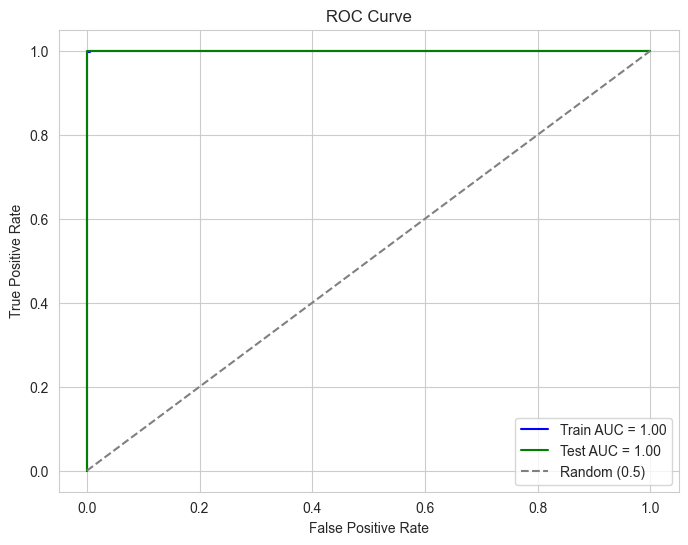

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC
fpr_train, tpr_train, _ = roc_curve(y_true_train, y_probs_train)
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_probs_test)

# Compute AUC
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.2f}", color="blue")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.2f}", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random (0.5)")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()